In [2]:
!pip install -U ydata-profiling[notebook]
import pandas as pd
from ydata_profiling import ProfileReport
df = pd.read_csv('/content/sample_data/car_sales_data.csv')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
profile = ProfileReport(
    df,
    title="EDA automático (duplicados, nulos, tipos, distribuciones, correlaciones, resumen)",
    explorative=True
)
profile.to_notebook_iframe()
profile.to_file("reporte_eda.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#Observaciones

- Duplicados: Se identificaron 11 filas duplicadas con coincidencia completa en las columnas clave mostradas (fabricante, modelo, tamaño de motor, tipo de combustible, año, kilometraje y precio), lo que sugiere registros repetidos que pueden sesgar distribuciones y métricas de correlación si no se depuran antes del modelado de precios.

- Valores nulos: La sección de valores nulos indica 0 celdas faltantes en todas las columnas y un porcentaje global de nulos de 0.0%

- Tipo de datos: las columnas Manufacturer, Model y Fuel type están como object (texto), Engine size es float64 y Year of manufacture, Mileage y Price son enteras (int64), lo cual es coherente para un análisis de pricing

- Las distribuciones muestran fuerte asimetría positiva en Precio y Kilometraje con colas largas, lo que sugiere pocos valores muy altos que pueden sesgar medias y correlaciones y que conviene tratar con transformaciones logarítmicas

- La matriz muestra que el Precio se correlaciona fuertemente en sentido positivo con Year of manufacture, y en sentido negativo con Mileage, coherente con depreciación por antigüedad/uso; Engine size tiene una correlación positiva moderada con el Precio, por lo que su efecto existe pero es menor frente a edad y kilometraje, y la fuerte correlación negativa entre Year of manufacture y Mileage advierte posible colinealidad

- Resumen estadistico: El resumen estadístico confirma 50 000 registros y evidencia asimetrías importantes: en Price la media es muy superior a la mediana, y en Mileage la media (≈112 497) también supera claramente su mediana, señales de colas derechas y outliers que inflan la media

##Tareas para la limpieza de datos
- Eliminar las 11 filas repetidas conservando una sola ocurrencia por combinación para evitar sesgos en estadísticas y correlaciones

- Tratamiento de asimetrías y outliers en Price y Mileage

#Necesidad de limpieza
- Duplicados: Existen 11 filas repetidas
- Valores nulos: No existen columnas con valores nulos
- Inconsistencias en valores: No existen inconsistencias en los valores del dataset
- Tipos de Datos: Cada columna cuenta con un tipo de dato adecuado para cada variable
- Valores atipicos: En el análisis de ventas de vehículos, los valores atípicos pueden ser especialmente problemáticos en las variables de precio, kilometraje, tamaño de motor y año de fabricación, ya que distorsionan los estadísticos resumen, afectan la interpretación de patrones típicos y pueden corresponder a errores de captura, unidades excepcionales o transacciones poco representativas del mercado real. En nuestro caso se utiliza la winsorizacion para el tratamiento de datos
- Granularidad: el dataset cuenta con una granularidad adecuada para el analisis

#Limpieza de datos

In [3]:
# Eliminacion de duplicados
df_clean = df.drop_duplicates(
    subset=["Manufacturer", "Model", "Engine size", "Fuel type", "Year of manufacture", "Mileage", "Price"],
    keep="first"  # opciones: "first", "last", False
).copy()

# Verifica que no hay duplicados restantes
num_dupes = df_clean.duplicated(
    subset=["Manufacturer", "Model", "Engine size", "Fuel type", "Year of manufacture", "Mileage", "Price"]
).sum()
print(f"Duplicados restantes: {num_dupes}")


Duplicados restantes: 0


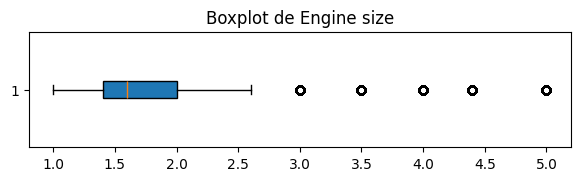

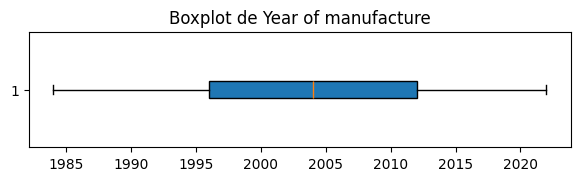

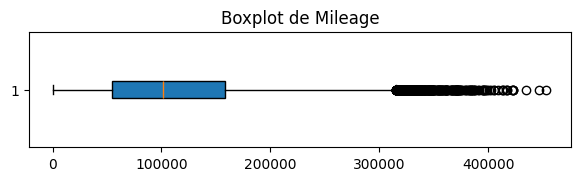

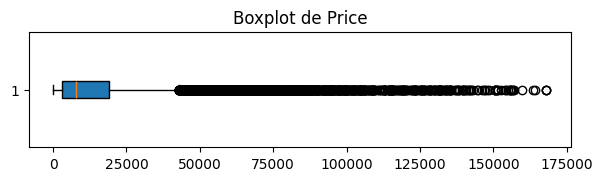

In [4]:
import matplotlib.pyplot as plt

# Lista de variables numéricas a analizar
num_vars = ["Engine size", "Year of manufacture", "Mileage", "Price"]

for col in num_vars:
    plt.figure(figsize=(7,1.5))
    plt.boxplot(df[col], vert=False, patch_artist=True)
    plt.title(f'Boxplot de {col}')
    plt.show()


In [5]:
import numpy as np

def winsorize_series(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return np.clip(series, lower_bound, upper_bound)

# Aplica winsorización a las columnas numéricas principales
for col in num_vars:
    df[col+"_win"] = winsorize_series(df[col])


#Validaciòn

In [6]:
df_clean = df.drop_duplicates(subset=["Manufacturer","Model","Engine size","Fuel type","Year of manufacture","Mileage","Price"]).copy()
print("Filas después de eliminar duplicados:", len(df_clean))


Filas después de eliminar duplicados: 49988


/tmp/ipython-input-3784429304.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_clean["Price"], df_clean["Price_win"]], vert=False, labels=["Original", "Winsorizado"])


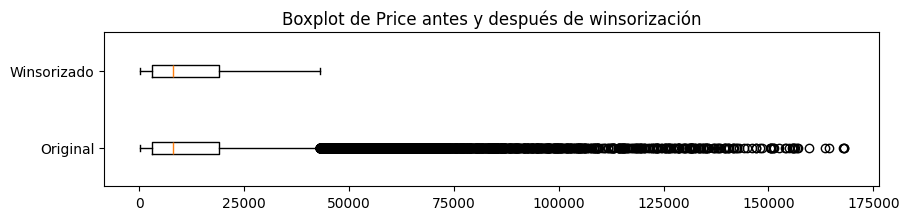

In [10]:
plt.figure(figsize=(10,2))
plt.boxplot([df_clean["Price"], df_clean["Price_win"]], vert=False, labels=["Original", "Winsorizado"])
plt.title("Boxplot de Price antes y después de winsorización")
plt.show()


In [8]:
# Compara estadísticos descriptivos antes y después
print("Antes:")
print(df["Price"].describe())

print("Después:")
print(df_clean["Price_win"].describe())


Antes:
count     50000.000000
mean      13828.903160
std       16416.681336
min          76.000000
25%        3060.750000
50%        7971.500000
75%       19026.500000
max      168081.000000
Name: Price, dtype: float64
Después:
count    49988.000000
mean     12724.781470
std      12308.772075
min         76.000000
25%       3059.750000
50%       7971.000000
75%      19028.500000
max      42975.125000
Name: Price_win, dtype: float64


Luego de la limpieza del dataset, se garantiza la completitud de los datos al eliminar duplicados y confirmar la ausencia de valores nulos en todas las columnas críticas, lo que asegura resultados confiables en análisis descriptivo y agrupaciones. La relevancia de las variables está validada porque cada columna incluida es pertinente para responder preguntas sobre ventas, atributos de vehículos y tendencias del mercado. Además, la granularidad es adecuada ya que cada fila representa una venta individual con el nivel de detalle necesario para proporcionar insights significativos sobre las características y comportamiento de las transacciones.

In [9]:
df_clean.to_csv("dataset_limpio.csv", index=False)
